In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.datasets import cifar10
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)

In [ ]:
# Noms des classes CIFAR-10
class_names = ['avion', 'voiture', 'oiseau', 'chat', 'cerf',
               'chien', 'grenouille', 'cheval', 'bateau', 'camion']

In [ ]:
# 1. Prétraitement des Données
def charger_et_preparer_donnees(n_samples=5000, train_ratio=0.7):
    # Chargement de CIFAR-10
    (X_train_full, y_train_full), (X_test_full, y_test_full) = cifar10.load_data()
    # Sauvegarde des images originales pour la visualisation
    X_train_images = X_train_full.copy()
    X_test_images = X_test_full.copy()
    # Sous-échantillonnage stratifié
    np.random.seed(42)
    indices_train = []
    indices_test = []
    # Calcul des échantillons par classe
    samples_per_class_train = int((n_samples * train_ratio) // 10)  # 350 pour 70%
    samples_per_class_test = int((n_samples * (1 - train_ratio)) // 10)  # 150 pour 30%
    for class_idx in range(10):
        class_indices_train = np.where(y_train_full.ravel() == class_idx)[0]
        class_indices_test = np.where(y_test_full.ravel() == class_idx)[0]
        selected_train = np.random.choice(
            class_indices_train,
            size=min(samples_per_class_train, len(class_indices_train)),
            replace=False
        )
        selected_test = np.random.choice(
            class_indices_test,
            size=min(samples_per_class_test, len(class_indices_test)),
            replace=False
        )

        indices_train.extend(selected_train)
        indices_test.extend(selected_test)
    # Créer sous-ensembles
    X_train = X_train_full[indices_train]
    y_train = y_train_full[indices_train]
    X_test = X_test_full[indices_test]
    y_test = y_test_full[indices_test]
    # Garder les images d'origine pour la visualisation
    X_train_images_sampled = X_train.copy()
    X_test_images_sampled = X_test.copy()
    # Convertir les images en vecteurs et normaliser
    X_train = X_train.reshape(X_train.shape[0], -1) / 255.0
    X_test = X_test.reshape(X_test.shape[0], -1) / 255.0

    # Standardisation
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    print(f"Forme des données d'entraînement: {X_train_scaled.shape}")
    print(f"Forme des données de test: {X_test_scaled.shape}")
    print(f"Taille entraînement : {len(X_train_scaled)} ({len(X_train_scaled)/n_samples*100:.1f}%)")
    print(f"Taille test : {len(X_test_scaled)} ({len(X_test_scaled)/n_samples*100:.1f}%)")

    return X_train_scaled, X_test_scaled, y_train.ravel(), y_test.ravel(), X_train_images_sampled, X_test_images_sampled, indices_train, indices_test

# 2. Séparation du Jeu de Données - Déjà fait dans la fonction précédente
# La séparation est maintenue à 70% train, 30% test comme demandé

In [ ]:
# 3. Modélisation avec SVM
def entrainer_svm(X_train, y_train, kernel='rbf', C=1.0, gamma='scale', verbose=True):
    if verbose:
        print(f"\nEntraînement SVM avec noyau {kernel}...")

    svm = SVC(kernel=kernel, C=C, gamma=gamma, random_state=42)
    svm.fit(X_train, y_train)

    if verbose:
        print(f"Entraînement terminé.")

    return svm

In [ ]:
# 4. Optimisation des Hyperparamètres
def optimiser_hyperparametres(X_train, y_train):
    print("\nOptimisation des hyperparamètres...")
    # Grille de paramètres réduite mais pertinente
    param_grid = {
        'C': [0.1, 1, 10],
        'gamma': ['scale', 0.01, 0.1]
    }

    grid_search = GridSearchCV(
        SVC(random_state=42),
        param_grid,
        cv=3,  # Réduit à 3 plis pour accélérer
        scoring='accuracy',
        n_jobs=-1  # Utilise tous les cœurs disponibles
    )

    grid_search.fit(X_train, y_train)

    print("Optimisation terminée.")
    print(f"Meilleurs paramètres: {grid_search.best_params_}")
    print(f"Score de validation: {grid_search.best_score_:.4f}")

    return grid_search.best_estimator_, grid_search.best_params_

In [ ]:
# 5. Analyse des Vecteurs Supports
def analyser_vecteurs_supports(svm, y_train):
    print("\nAnalyse des Vecteurs Supports:")
    print(f"Nombre total de vecteurs supports: {len(svm.support_vectors_)}")

    # Répartition par classe
    for i in range(10):
        mask = (y_train[svm.support_] == i)
        nb_vs_classe = np.sum(mask)
        print(f"Classe {class_names[i]}: {nb_vs_classe} vecteurs supports")


In [ ]:
# 6. Visualisation des Frontières de Décision
def visualiser_frontieres(X_train, y_train, svm, max_samples=1000):
    print("\nPréparation de la visualisation des frontières de décision...")

    # Sous-échantillonnage pour la visualisation si nécessaire
    if len(X_train) > max_samples:
        indices = np.random.choice(len(X_train), max_samples, replace=False)
        X_viz = X_train[indices]
        y_viz = y_train[indices]
    else:
        X_viz = X_train
        y_viz = y_train

    # Réduction à 2 dimensions pour visualisation
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_viz)

    print(f"Variance expliquée par les 2 premières composantes: {np.sum(pca.explained_variance_ratio_):.2f}")

    # Entraînement SVM sur les données PCA
    svm_pca = SVC(kernel='rbf')
    svm_pca.fit(X_pca, y_viz)

    # Création du plot
    plt.figure(figsize=(10, 8))

    # Plot des points de données
    scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_viz, cmap='viridis', alpha=0.7, s=30)
    plt.colorbar(scatter, label='Classes')

    # Création de la grille pour les frontières de décision
    x_min, x_max = X_pca[:, 0].min() - 1, X_pca[:, 0].max() + 1
    y_min, y_max = X_pca[:, 1].min() - 1, X_pca[:, 1].max() + 1

    # Utiliser un pas plus grand pour accélérer
    h = 0.2
    xx, yy = np.meshgrid(
        np.arange(x_min, x_max, h),
        np.arange(y_min, y_max, h)
    )

    # Prédiction sur la grille
    print("Calcul des frontières de décision (peut prendre un moment)...")
    Z = svm_pca.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # Tracé des frontières de décision
    plt.contourf(xx, yy, Z, alpha=0.3, cmap='viridis')

    # Tracé des vecteurs supports
    plt.scatter(
        X_pca[svm_pca.support_, 0],
        X_pca[svm_pca.support_, 1],
        s=100,
        linewidth=1,
        facecolors='none',
        edgecolors='r'
    )

    plt.title('Frontières de Décision SVM (Projection PCA)')
    plt.xlabel('1ère Composante Principale')
    plt.ylabel('2ème Composante Principale')
    plt.show()

In [ ]:
# 7. Évaluation du Modèle
def evaluer_modele(svm, X_test, y_test, model_name="SVM"):
    print(f"\nÉvaluation du modèle {model_name}:")

    # Prédiction
    y_pred = svm.predict(X_test)

    # Métriques principales
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")

    # Rapport de classification plus détaillé
    print("\nRapport de classification détaillé:")
    print(classification_report(y_test, y_pred, target_names=class_names))

    # Matrice de confusion
    plt.figure(figsize=(10, 8))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Matrice de Confusion - {model_name}')
    plt.xlabel('Prédictions')
    plt.ylabel('Vraies Valeurs')
    plt.tight_layout()
    plt.show()

    return accuracy, precision, recall, f1, y_pred

In [ ]:
# ======= FONCTIONS DE VISUALISATION DES IMAGES =======

# Fonction pour afficher une grille d'images
def plot_images(images, labels, predictions=None, num_rows=5, num_cols=5):
    plt.figure(figsize=(12, 12))
    for i in range(min(num_rows * num_cols, len(images))):
        plt.subplot(num_rows, num_cols, i+1)
        plt.imshow(images[i])

        if predictions is not None:
            title_color = 'green' if predictions[i] == labels[i] else 'red'
            plt.title(f"Vraie: {class_names[labels[i]]}\nPred: {class_names[predictions[i]]}",
                      color=title_color)
        else:
            plt.title(f"{class_names[labels[i]]}")

        plt.axis('off')
    plt.tight_layout()
    plt.show()

In [ ]:
# 1. Visualiser quelques exemples aléatoires du dataset
def show_random_examples(X_images, y_labels, n_examples=25):
    print("\nAffichage d'exemples aléatoires du dataset:")
    indices = np.random.choice(len(X_images), n_examples, replace=False)
    plot_images(X_images[indices], y_labels[indices])

In [ ]:
# 2. Visualiser des exemples par classe
def show_examples_per_class(X_images, y_labels):
    print("\nAffichage d'exemples par classe:")
    for class_id in range(10):
        class_indices = np.where(y_labels == class_id)[0][:9]  # Prendre 9 exemples de cette classe
        if len(class_indices) > 0:
            plt.figure(figsize=(10, 10))
            for i, idx in enumerate(class_indices):
                plt.subplot(3, 3, i+1)
                plt.imshow(X_images[idx])
                plt.title(class_names[class_id])
                plt.axis('off')
            plt.suptitle(f"Exemples de la classe: {class_names[class_id]}", fontsize=16)
            plt.tight_layout()
            plt.show()

In [ ]:
# 3. Visualiser les erreurs de classification
def show_classification_errors(X_images, y_labels, predictions, num_errors=25):
    print("\nAffichage des erreurs de classification:")
    # Trouver les indices où les prédictions sont incorrectes
    error_indices = np.where(predictions != y_labels)[0]

    if len(error_indices) > 0:
        selected_errors = error_indices[:min(num_errors, len(error_indices))]
        plot_images(X_images[selected_errors], y_labels[selected_errors], predictions[selected_errors],
                    num_rows=5, num_cols=5)
    else:
        print("Aucune erreur trouvée!")

In [ ]:
# 4. Visualiser les confusions spécifiques (ex: chats prédits comme chiens)
def show_specific_confusion(X_images, y_labels, predictions, true_class, predicted_class, num_examples=9):
    print(f"\nAnalyse des confusions entre {class_names[true_class]} et {class_names[predicted_class]}:")
    # Trouver les indices des exemples mal classifiés d'une manière spécifique
    confusion_indices = np.where((y_labels == true_class) &
                                 (predictions == predicted_class))[0]

    if len(confusion_indices) > 0:
        selected_examples = confusion_indices[:min(num_examples, len(confusion_indices))]
        plt.figure(figsize=(10, 10))
        for i, idx in enumerate(selected_examples):
            plt.subplot(3, 3, i+1)
            plt.imshow(X_images[idx])
            plt.title(f"Vraie: {class_names[true_class]}\nPred: {class_names[predicted_class]}")
            plt.axis('off')
        plt.suptitle(f"Confusions {class_names[true_class]} → {class_names[predicted_class]}", fontsize=16)
        plt.tight_layout()
        plt.show()
    else:
        print(f"Aucune confusion {class_names[true_class]} → {class_names[predicted_class]} trouvée!")

=== Classification CIFAR-10 avec SVM (Version Complète) ===
170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
Forme des données d'entraînement: (3500, 3072)
Forme des données de test: (1500, 3072)
Taille entraînement : 3500 (70.0%)
Taille test : 1500 (30.0%)

Affichage d'exemples aléatoires du dataset:


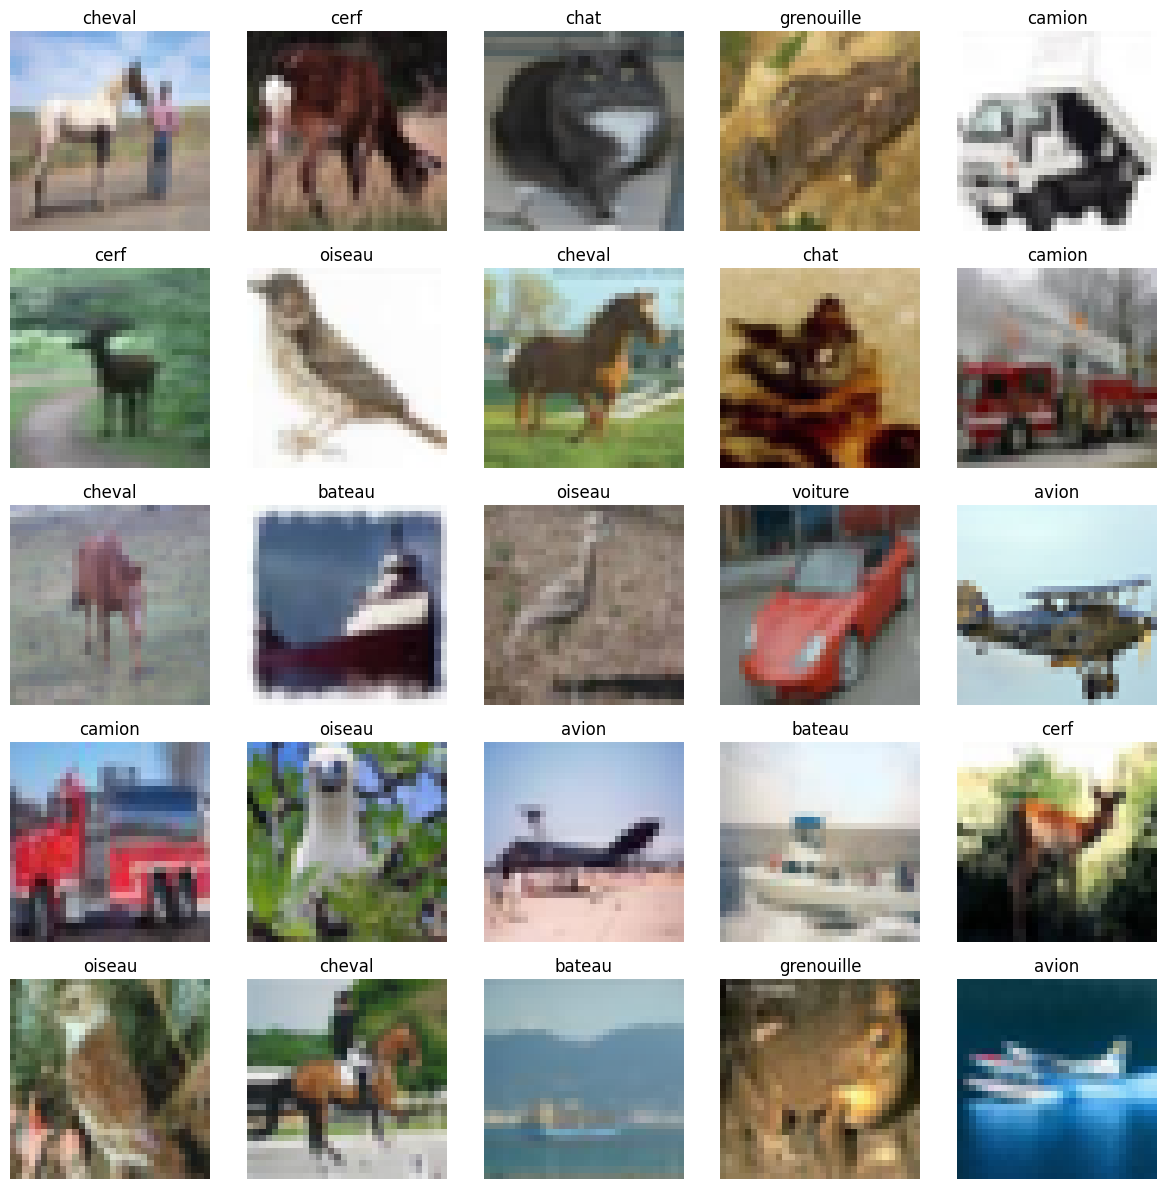


--- SVM Non Linéaire (RBF) ---

Entraînement SVM avec noyau rbf...
Entraînement terminé.

--- SVM Linéaire ---

Entraînement SVM avec noyau linear...
Entraînement terminé.

--- Optimisation des Hyperparamètres ---

Optimisation des hyperparamètres...
Optimisation terminée.
Meilleurs paramètres: {'C': 10, 'gamma': 'scale'}
Score de validation: 0.4006

Analyse des Vecteurs Supports:
Nombre total de vecteurs supports: 3403
Classe avion: 331 vecteurs supports
Classe voiture: 343 vecteurs supports
Classe oiseau: 349 vecteurs supports
Classe chat: 350 vecteurs supports
Classe cerf: 346 vecteurs supports
Classe chien: 346 vecteurs supports
Classe grenouille: 338 vecteurs supports
Classe cheval: 340 vecteurs supports
Classe bateau: 317 vecteurs supports
Classe camion: 343 vecteurs supports

Préparation de la visualisation des frontières de décision...
Variance expliquée par les 2 premières composantes: 1.00
Calcul des frontières de décision (peut prendre un moment)...


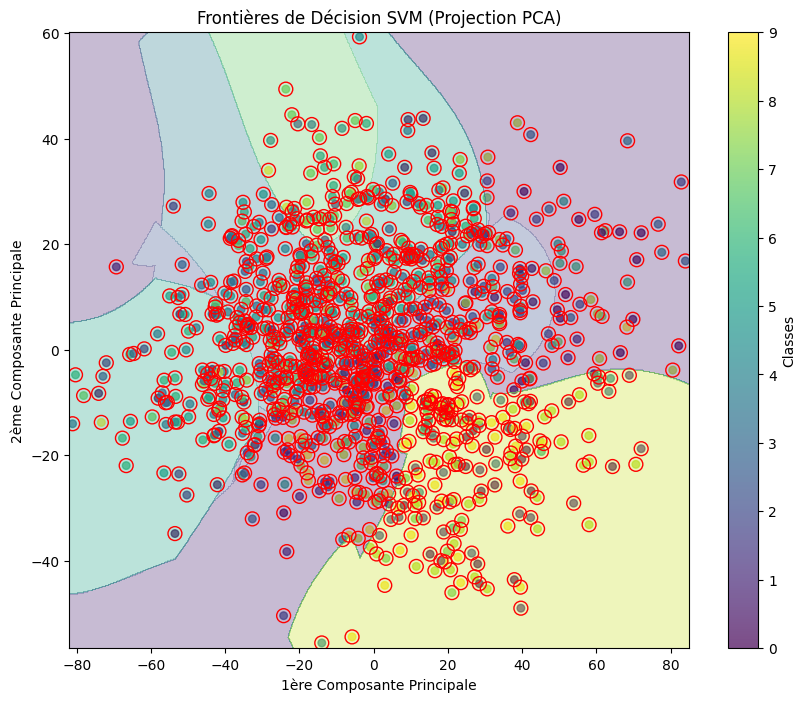


=== Évaluation comparative des modèles ===

Évaluation du modèle SVM RBF:
Accuracy: 0.4293
Precision: 0.4246
Recall: 0.4293
F1-score: 0.4238

Rapport de classification détaillé:
              precision    recall  f1-score   support

       avion       0.50      0.51      0.50       150
     voiture       0.49      0.56      0.53       150
      oiseau       0.22      0.18      0.20       150
        chat       0.25      0.24      0.24       150
        cerf       0.40      0.39      0.39       150
       chien       0.45      0.41      0.43       150
  grenouille       0.45      0.59      0.51       150
      cheval       0.52      0.37      0.43       150
      bateau       0.51      0.61      0.55       150
      camion       0.47      0.45      0.46       150

    accuracy                           0.43      1500
   macro avg       0.42      0.43      0.42      1500
weighted avg       0.42      0.43      0.42      1500



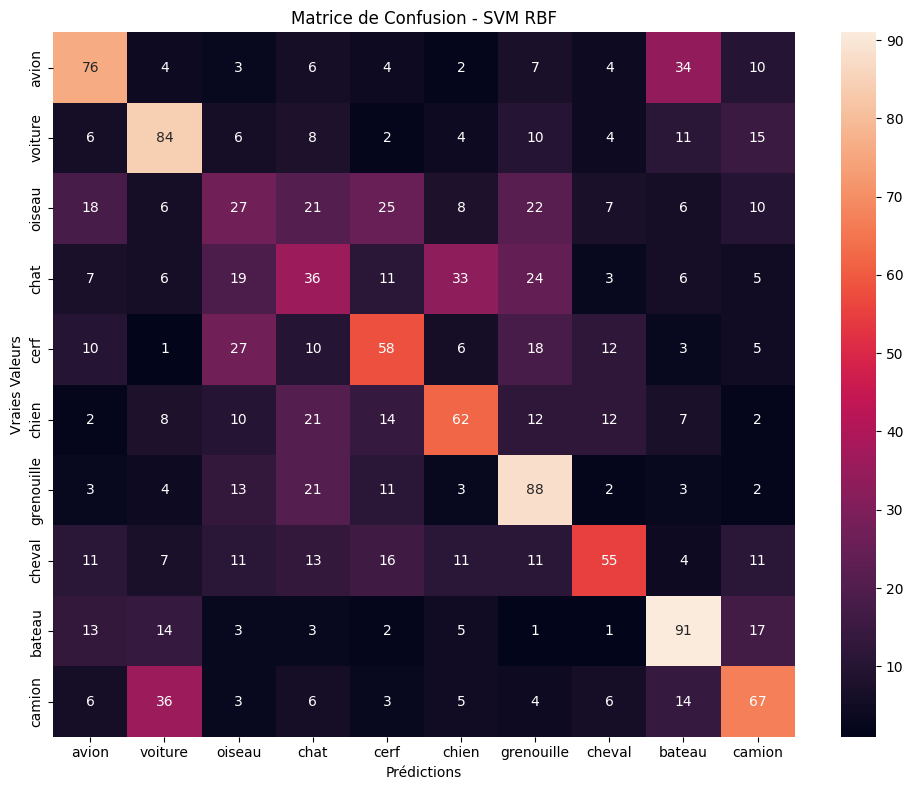


Évaluation du modèle SVM Linéaire:
Accuracy: 0.2880
Precision: 0.2970
Recall: 0.2880
F1-score: 0.2890

Rapport de classification détaillé:
              precision    recall  f1-score   support

       avion       0.29      0.42      0.34       150
     voiture       0.35      0.37      0.36       150
      oiseau       0.16      0.18      0.17       150
        chat       0.20      0.21      0.21       150
        cerf       0.27      0.27      0.27       150
       chien       0.24      0.24      0.24       150
  grenouille       0.40      0.29      0.33       150
      cheval       0.29      0.29      0.29       150
      bateau       0.35      0.34      0.35       150
      camion       0.41      0.28      0.33       150

    accuracy                           0.29      1500
   macro avg       0.30      0.29      0.29      1500
weighted avg       0.30      0.29      0.29      1500



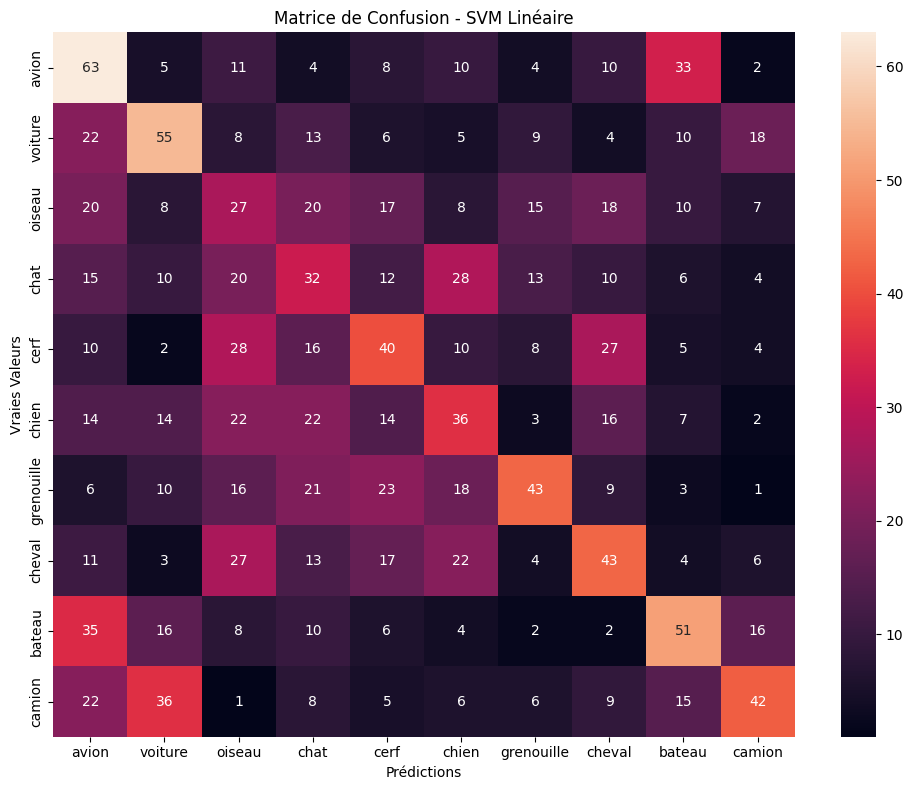


Évaluation du modèle SVM Optimisé:
Accuracy: 0.4280
Precision: 0.4343
Recall: 0.4280
F1-score: 0.4287

Rapport de classification détaillé:
              precision    recall  f1-score   support

       avion       0.49      0.55      0.52       150
     voiture       0.47      0.56      0.51       150
      oiseau       0.27      0.26      0.27       150
        chat       0.23      0.27      0.24       150
        cerf       0.37      0.39      0.38       150
       chien       0.41      0.41      0.41       150
  grenouille       0.55      0.49      0.52       150
      cheval       0.52      0.38      0.44       150
      bateau       0.53      0.56      0.55       150
      camion       0.50      0.41      0.45       150

    accuracy                           0.43      1500
   macro avg       0.43      0.43      0.43      1500
weighted avg       0.43      0.43      0.43      1500



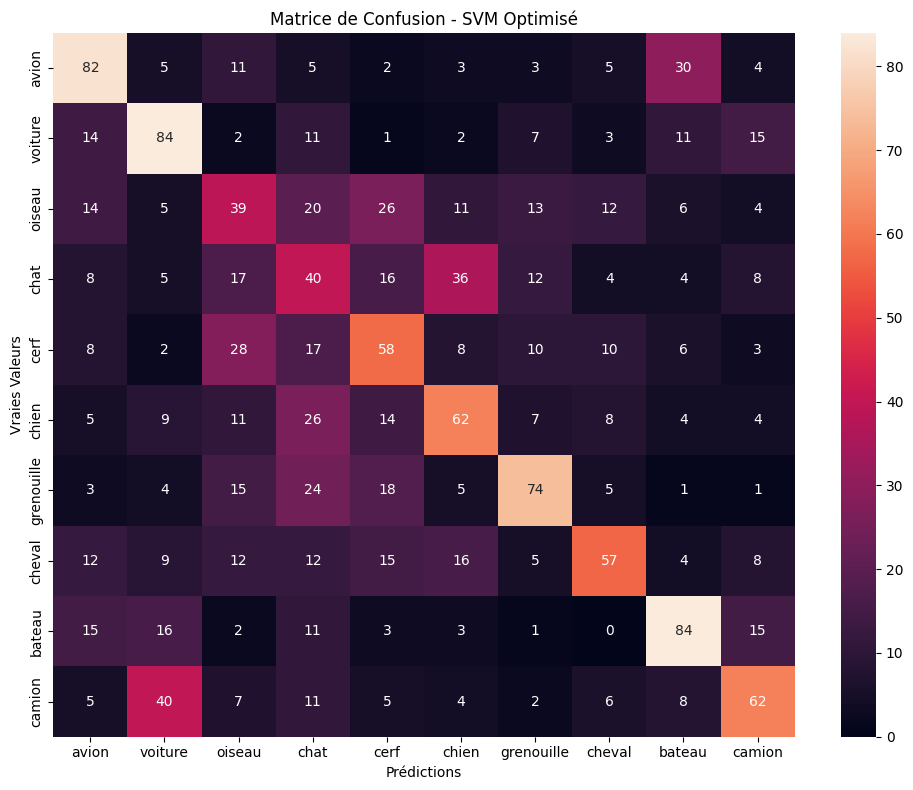


=== Visualisation des erreurs de classification ===

Affichage des erreurs de classification:


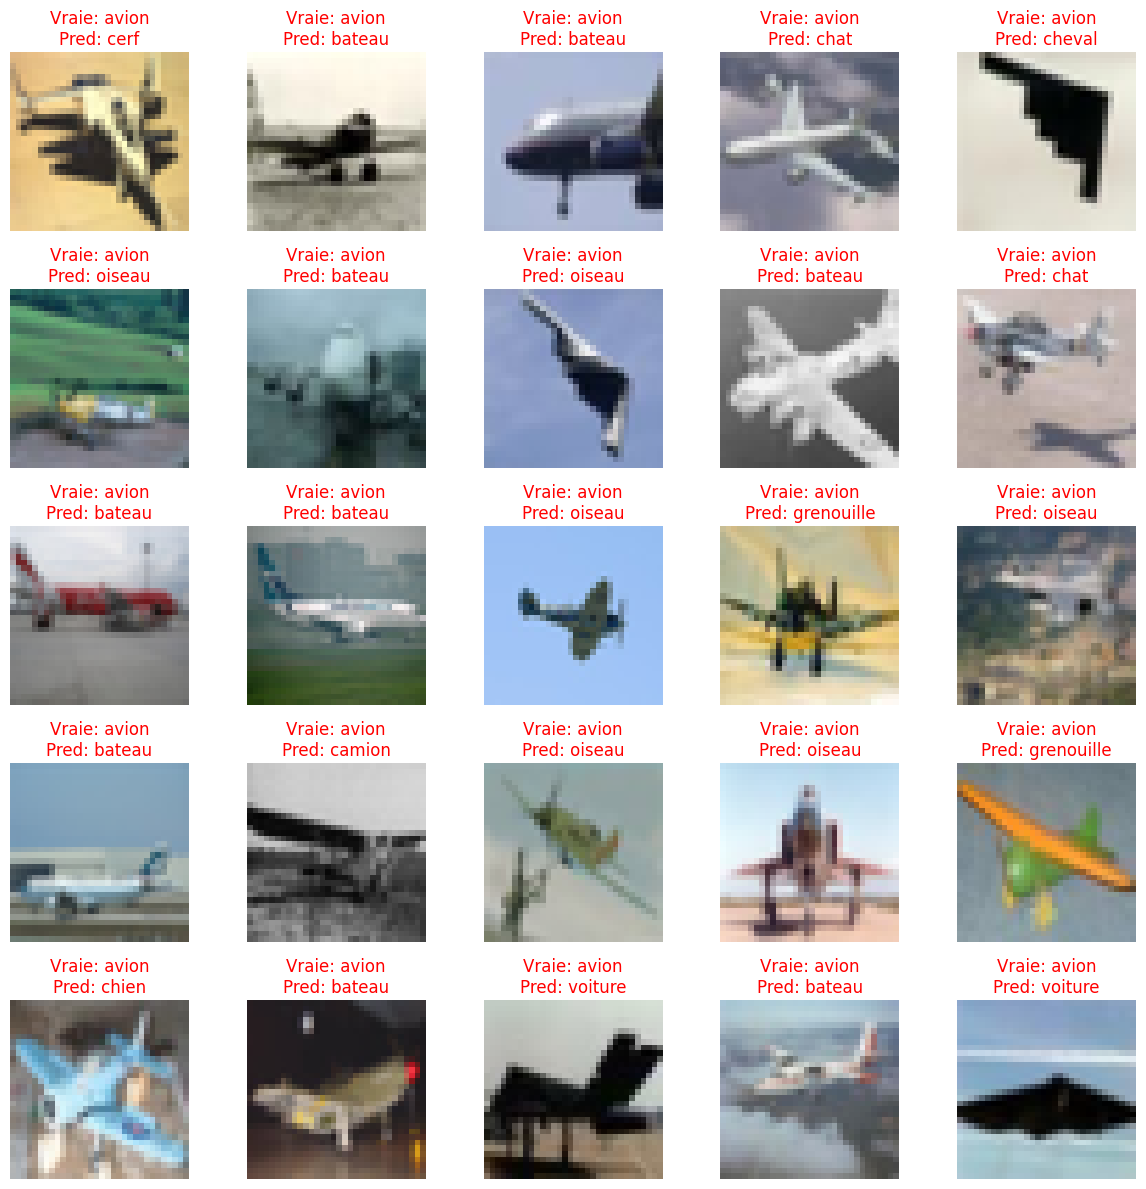


=== Analyse de confusions spécifiques ===

Analyse des confusions entre chat et chien:


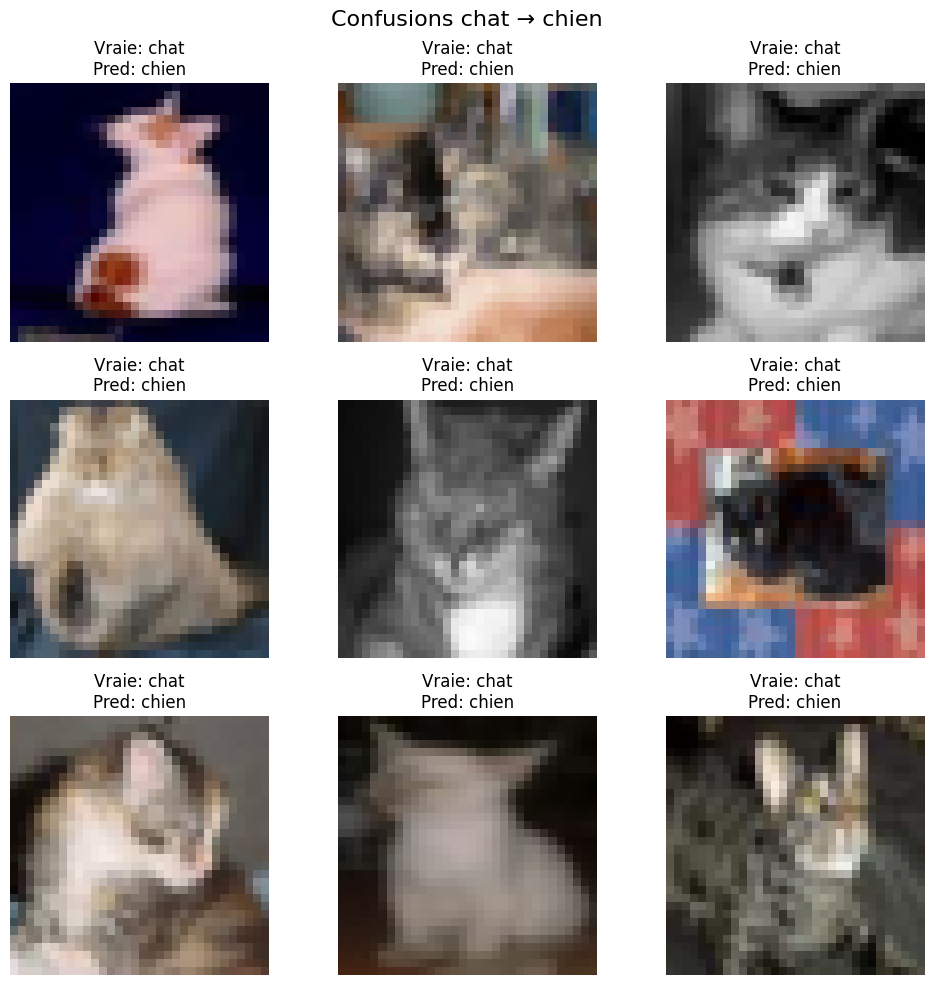


Analyse des confusions entre oiseau et avion:


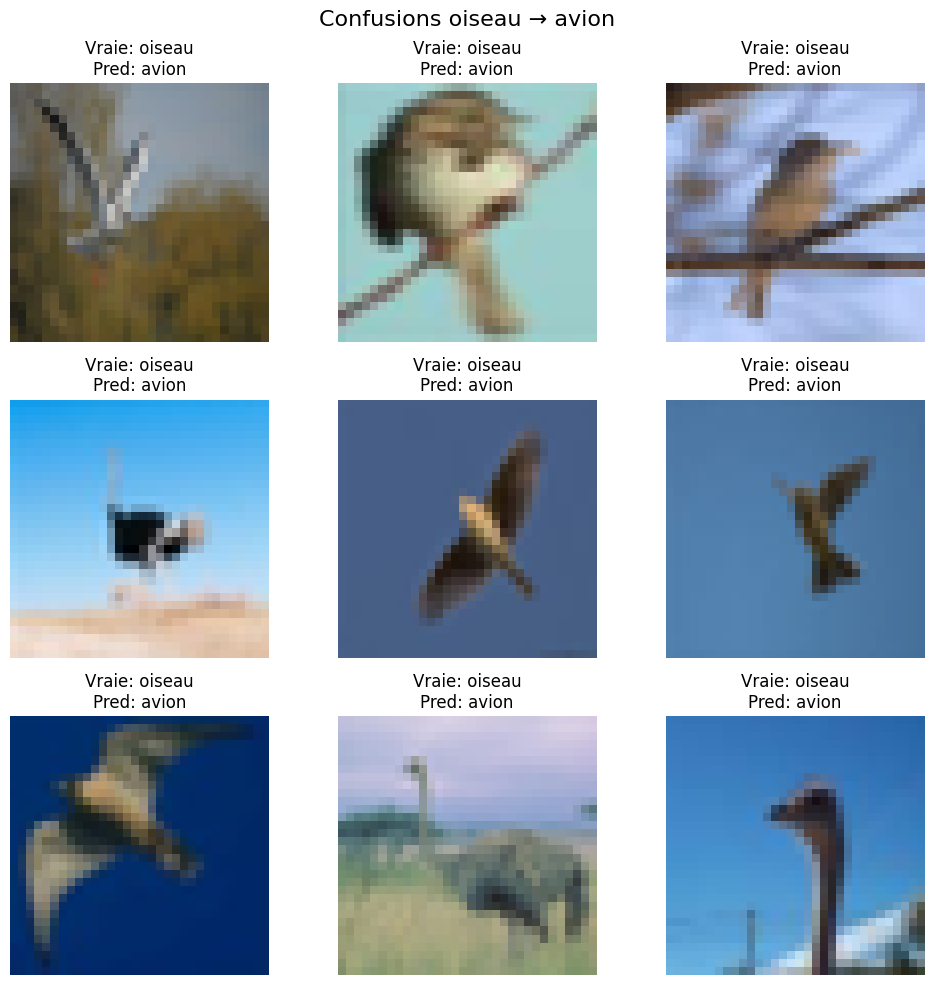


Analyse des confusions entre voiture et camion:


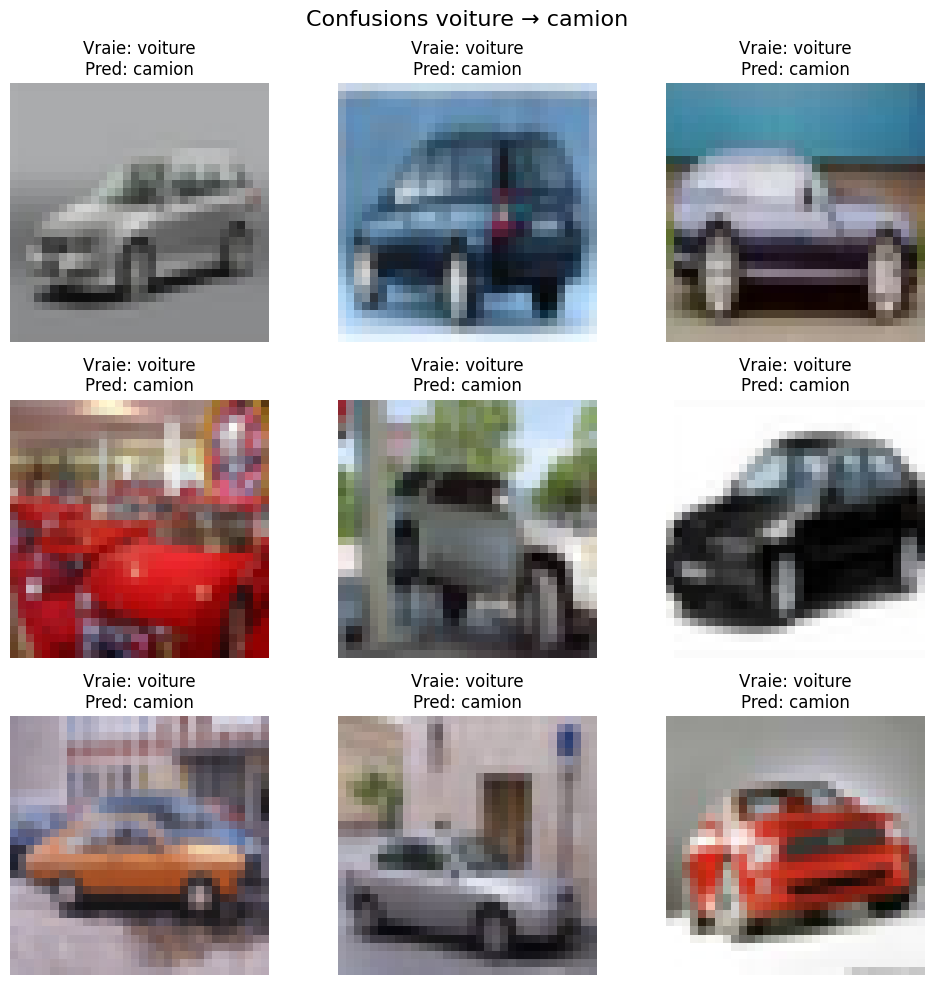


=== Comparaison des performances ===


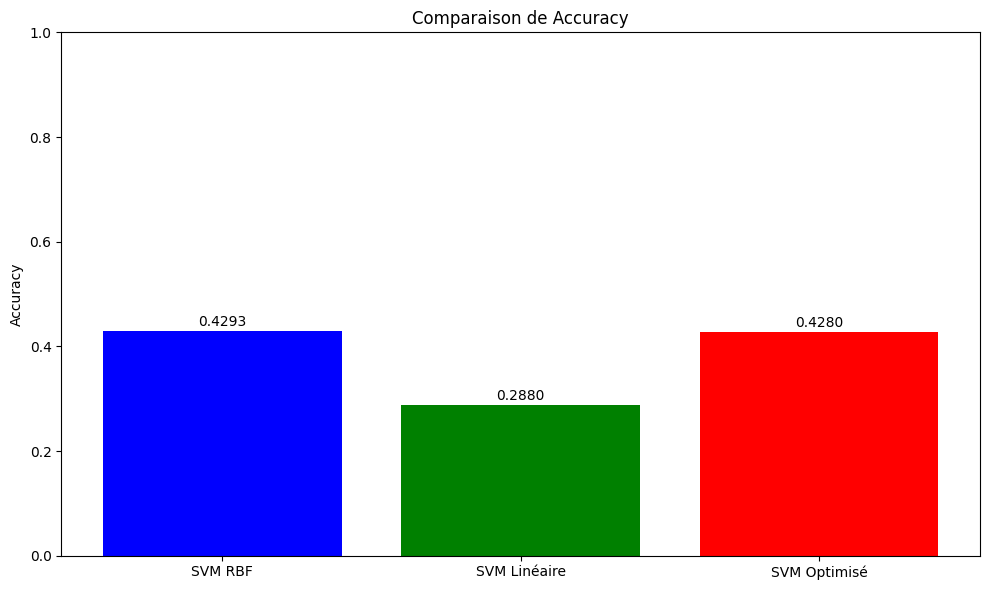

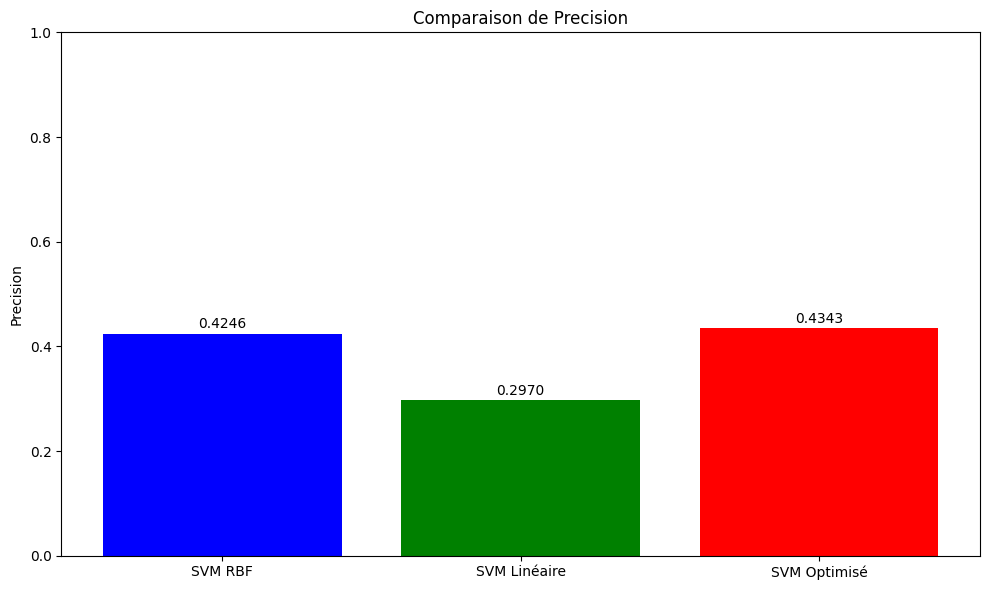

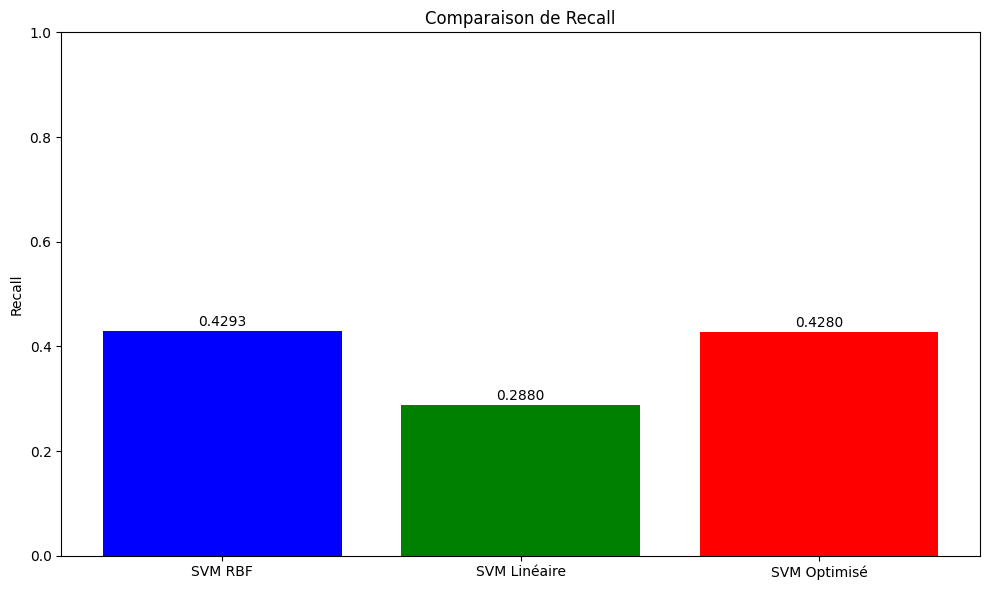

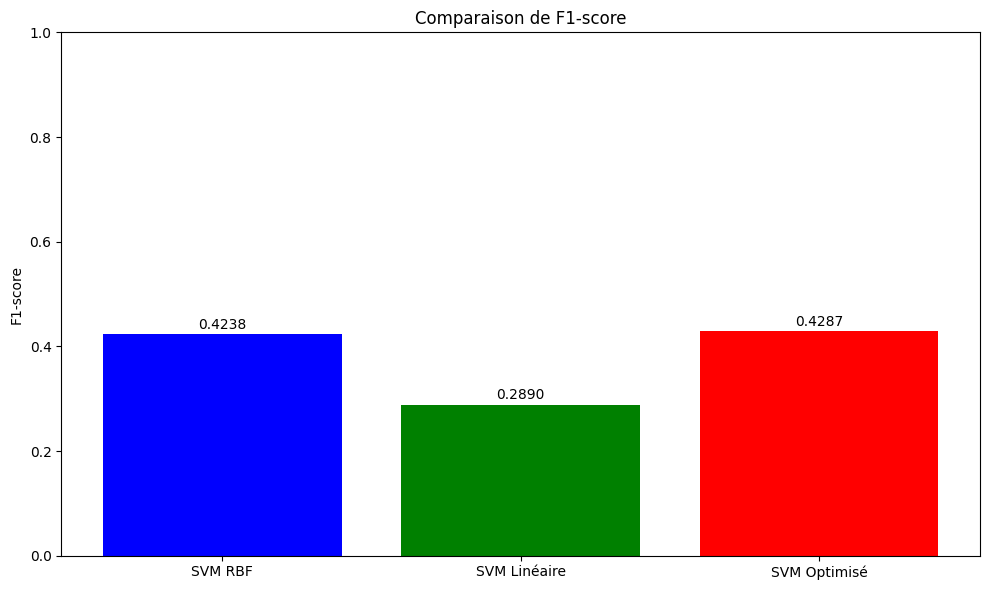


=== Résumé des performances ===


NameError: name 'pd' is not defined

In [ ]:
def main():
    print("=== Classification CIFAR-10 avec SVM (Version Complète) ===")

    # 1. Prétraitement des Données
    # Utiliser un sous-ensemble de CIFAR-10 pour accélérer l'exécution avec 70% train et 30% test
    X_train, X_test, y_train, y_test, X_train_images, X_test_images, indices_train, indices_test = charger_et_preparer_donnees(n_samples=5000, train_ratio=0.7)

    # Visualisation des données d'origine
    show_random_examples(X_train_images, y_train)

    # Optionnel: afficher des exemples par classe
    # show_examples_per_class(X_train_images, y_train)

    # 3. Modélisation SVM
    print("\n--- SVM Non Linéaire (RBF) ---")
    svm_rbf = entrainer_svm(X_train, y_train, kernel='rbf')

    print("\n--- SVM Linéaire ---")
    svm_lin = entrainer_svm(X_train, y_train, kernel='linear')

    # 4. Optimisation des Hyperparamètres
    print("\n--- Optimisation des Hyperparamètres ---")
    svm_optimise, meilleurs_params = optimiser_hyperparametres(X_train, y_train)

    # 5. Analyse des Vecteurs Supports
    analyser_vecteurs_supports(svm_rbf, y_train)

    # 6. Visualisation des Frontières
    # Réduire les données à 2D pour la visualisation
    from sklearn.decomposition import PCA
    pca = PCA(n_components=2)
    X_train_2d = pca.fit_transform(X_train)
    visualiser_frontieres(X_train_2d, y_train, svm_rbf)

    # 7. Évaluation des Modèles
    print("\n=== Évaluation comparative des modèles ===")

    # Évaluer modèle RBF
    rbf_scores = evaluer_modele(svm_rbf, X_test, y_test, "SVM RBF")
    y_pred_rbf = rbf_scores[4]  # Récupérer les prédictions

    # Évaluer modèle linéaire
    lin_scores = evaluer_modele(svm_lin, X_test, y_test, "SVM Linéaire")
    y_pred_lin = lin_scores[4]  # Récupérer les prédictions

    # Évaluer modèle optimisé
    opt_scores = evaluer_modele(svm_optimise, X_test, y_test, "SVM Optimisé")
    y_pred_opt = opt_scores[4]  # Récupérer les prédictions

    # Visualisation des erreurs de classification
    print("\n=== Visualisation des erreurs de classification ===")

    # Visualiser les erreurs du modèle optimisé
    show_classification_errors(X_test_images, y_test, y_pred_opt)

    # Visualiser des confusions spécifiques communes
    print("\n=== Analyse de confusions spécifiques ===")
    # Chats (3) classifiés comme chiens (5)
    show_specific_confusion(X_test_images, y_test, y_pred_opt, 3, 5)
    # Oiseaux (2) classifiés comme avions (0)
    show_specific_confusion(X_test_images, y_test, y_pred_opt, 2, 0)
    # Voitures (1) classifiées comme camions (9)
    show_specific_confusion(X_test_images, y_test, y_pred_opt, 1, 9)

    # Comparaison des résultats
    print("\n=== Comparaison des performances ===")
    modeles = ["SVM RBF", "SVM Linéaire", "SVM Optimisé"]
    scores = [
        [rbf_scores[0], rbf_scores[1], rbf_scores[2], rbf_scores[3]],
        [lin_scores[0], lin_scores[1], lin_scores[2], lin_scores[3]],
        [opt_scores[0], opt_scores[1], opt_scores[2], opt_scores[3]]
    ]

    metriques = ["Accuracy", "Precision", "Recall", "F1-score"]
    for i, metrique in enumerate(metriques):
        plt.figure(figsize=(10, 6))
        values = [score[i] for score in scores]
        bars = plt.bar(modeles, values, color=['blue', 'green', 'red'])
        plt.title(f'Comparaison de {metrique}')
        plt.ylabel(metrique)
        plt.ylim(0, 1)

        # Corriger le positionnement du texte en utilisant la position x des barres
        for j, bar in enumerate(bars):
            plt.text(bar.get_x() + bar.get_width()/2, values[j] + 0.01,
                    f"{values[j]:.4f}", ha='center')

        plt.tight_layout()
        plt.show()

    # Afficher un résumé des performances des modèles
    print("\n=== Résumé des performances ===")
    performance_df = pd.DataFrame(scores, columns=metriques, index=modeles)
    print(performance_df)

    # Sauvegarder les modèles (optionnel)
    # joblib.dump(svm_optimise, 'svm_cifar10_optimise.pkl')

    print("\n=== Classification terminée ===")

if __name__ == "__main__":
    main()